In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [2]:
import argparse
import random
import math
import json
import time 
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from rich import print as rprint
from typing import Dict, List
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessorList
import matplotlib.pyplot as plt


torch.manual_seed(42)

In [3]:
model_name = "meta-llama/Llama-2-7b-hf"
#model_name = "EleutherAI/pythia-1b"
#model_name = "/assets/models/meta-llama-3.1-8b"
load_model = True

In [4]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    device_map="auto")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

if load_model:
    model = AutoModelForCausalLM.from_pretrained(model_name,
                                                 device_map="auto")
    model.resize_token_embeddings(len(tokenizer))
    model.eval()

    
# extract the embed_token layer and purge the model from memory
w = model.model.embed_tokens.weight.data.detach().clone()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
del model
import gc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [6]:
device = torch.device("cuda")
print("Using device: ", device)

Using device:  cuda


#### Dataset with `[X,y]` with `X=h(t)` and `y=token(t)`

#### Create the dataset

#### Load the dataset

In [7]:
model_suffix = model_name.split("/")[-1]

X_dataset = torch.load(f"data/X_dataset_{model_suffix}.pt")
y_dataset = torch.load(f"data/y_dataset_{model_suffix}.pt")

/tmp/ipykernel_2759739/2044593793.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_dataset = torch.load(f"data/X_dataset_{model_suffix}.pt")


KeyboardInterrupt: 

In [8]:
dataset_size = X_dataset.shape[0]
perm = torch.randperm(dataset_size)

train_size = int(0.8 * dataset_size)

X_train, y_train = X_dataset[ perm[:train_size] ], y_dataset[ perm[:train_size] ]
X_val, y_val = X_dataset[ perm[train_size:] ], y_dataset[ perm[train_size:] ]

In [9]:
print("Train Dataset Size: ", X_train.shape)
print("Val Dataset Size: ", X_val.shape)
hidden_dim = X_dataset.shape[1]

Train Dataset Size:  torch.Size([1310720, 4096])
Val Dataset Size:  torch.Size([327680, 4096])


In [10]:
# Compute the mean and standard deviation
mean = torch.mean(X_train, dim=0)
std = torch.std(X_train, dim=0)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

In [11]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

### Linear probe for current token classification

- Derive soft labels from inverse transformations of token embeddings using the psuedoinverse of the embedding layer matrix
- Train linear model without bias using MSE loss

#### Train the model

In [12]:
#w = model.gpt_neox.embed_in.weight.data
#w = model.model.embed_tokens.weight.data
mean = torch.mean(w)
std_dev = torch.std(w)
print("Mean:", mean.item())
print("Standard Deviation:", std_dev.item())
w_pinv = torch.pinverse(w)
vocab_size = len(tokenizer)

# Initialize linear model with w_pinv   
# with torch.no_grad():
#     linear_nn.fc1.weight.copy_(w_pinv.T)

Mean: -4.74090084026102e-05
Standard Deviation: 0.016960974782705307


In [13]:
# Reconstruct all embeddings using w_pinv

# w_chunks = torch.chunk(w, torch.cuda.device_count(), dim=0)

# results = []
# for i, w_chunk in enumerate(w_chunks):
#     with torch.cuda.device(i):
#         results.append(torch.matmul(w_chunk.cuda(i), w_pinv.cuda(i)))

# results = [result.to("cuda:1") for result in results]

# one_hot_recon = torch.cat(results, dim=0)

one_hot_recon = torch.matmul(w, w_pinv)


# Find the indices of the maximum values in the reconstructions
predicted_indices = one_hot_recon.argmax(dim=1)
# Count how many predictions match their respective indices
correct_count = (predicted_indices == torch.arange(vocab_size, device=device)).sum().item()

accuracy = correct_count / vocab_size
print(f"Accuracy of w_pinv assigning max value to the right token: {accuracy * 100:.2f}%")

Accuracy of w_pinv assigning max value to the right token: 99.65%


In [14]:
def find_clusters(tensor, K):
    clusters = []
    for k in range(K, 0, -1):
        _, top_k_indices = torch.topk(tensor, k, dim=1)

        sorted_top_k_indices = torch.sort(top_k_indices, dim=1)[0]

        unique_rows, inverse_indices, counts = torch.unique(
            sorted_top_k_indices, dim=0, return_inverse=True, return_counts=True)

        k_clusters = unique_rows[counts == k]
        k_clusters_indices = inverse_indices[k_clusters]
        row_equality = (k_clusters_indices ==
                        k_clusters_indices[:, 0:1]).all(dim=1)
        assert row_equality.all(), "Row equality check failed!"

        # Remove subsets of the last added list of larger clusters
        valid_clusters = []
        if len(clusters) > 0:  
            # Check against all indices of every cluster
            indices = set(torch.cat([c.flatten() for c in clusters], dim=0).tolist())
            mask = torch.tensor([
                set(row.tolist()).issubset(indices) for row in k_clusters
            ])
            valid_clusters = k_clusters[~mask]

        else:  # If no larger clusters exist, all are valid
            valid_clusters = k_clusters

        clusters.append(valid_clusters)

    # for each tensor in cluster, convert to list of 1D tensors
    clusters = [cluster.tolist() for cluster in clusters]
    # create on giant list of clusters
    clusters = [cluster for sublist in clusters for cluster in sublist]
    return clusters


clusters = find_clusters(one_hot_recon, 6)

In [15]:
# flatten the clusters
flat_clusters = [item for sublist in clusters for item in sublist]
# check for duplicates
assert len(flat_clusters) == len(set(flat_clusters)), "Duplicates found in clusters"

# convert list of lists to list of tensors
clusters = [torch.tensor(cluster, device=one_hot_recon.device) for cluster in clusters]

In [16]:
# Initialize a new tensor to store the merged values
merged_one_hot_recon = torch.zeros((len(clusters), len(clusters)), device=one_hot_recon.device)

merged_rows = torch.stack([one_hot_recon[c].mean(dim=0) for c in clusters])


merged_one_hot_recon = torch.stack(
    [merged_rows[:, c].mean(dim=1) for c in clusters],
    dim=1
)


In [17]:
# create a 1 dimensional tensor of size vocab_size to store the indices of the merged clusters
index_map = torch.zeros(vocab_size, device=one_hot_recon.device, dtype=torch.long)
for i, cluster in enumerate(clusters):
    for index in cluster:
        index_map[index] = i     


In [18]:
class LinearProbe(nn.Module):
    def __init__(self, hdim=hidden_dim, vocab_size=merged_one_hot_recon.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(hdim, vocab_size, bias=False)

    def forward(self, X):
        x = self.fc1(X)
        return x


linear_nn = LinearProbe()
linear_nn.to(device)

LinearProbe(
  (fc1): Linear(in_features=4096, out_features=20469, bias=False)
)

In [19]:
# Normalize reconstructions
row_min = torch.min(merged_one_hot_recon, dim=1, keepdim=True)[0]
row_max = torch.max(merged_one_hot_recon, dim=1, keepdim=True)[0]
range_vals = row_max - row_min
# Perform min-max scaling for each row
scaled_matrix = (merged_one_hot_recon - row_min) / range_vals
# Control sparisty by raising the scaled values to a power
exp = 2
scaled_matrix = torch.pow(scaled_matrix, exp)

(array([8.400e+01, 1.261e+03, 3.301e+03, 3.243e+03, 2.643e+03, 2.845e+03,
        2.652e+03, 1.977e+03, 1.155e+03, 6.340e+02, 3.040e+02, 1.430e+02,
        8.400e+01, 4.000e+01, 2.300e+01, 1.800e+01, 8.000e+00, 6.000e+00,
        3.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

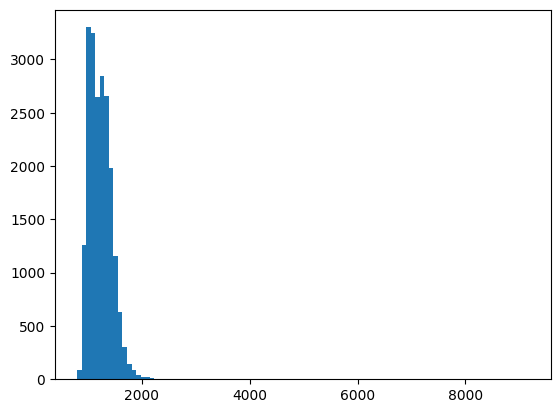

In [20]:
# Measure sparisty of each row in reconstructions with sum
sparsity = torch.sum(scaled_matrix, dim=1)
# plot histogram of sparsity
plt.hist(sparsity.cpu().numpy(), bins=100)

In [21]:
class WeightedMSELoss(nn.Module):
    def __init__(self, label_weight, penalty_weight):
        super(WeightedMSELoss, self).__init__()
        self.label_weight = label_weight
        self.penalty_weight = penalty_weight

    def forward(self, predictions, soft_labels, label_indices):
        """
        Args:
            predictions (torch.Tensor): Model predictions of shape (batch_size, num_classes).
            soft_labels (torch.Tensor): Ground truth soft labels of shape (batch_size, num_classes).
            label_indices (torch.Tensor): Indices of the target label for each batch item. Shape (batch_size,).

        Returns:
            torch.Tensor: The weighted MSE loss.
        """
        batch_size, _ = predictions.size()
        weights = torch.ones_like(predictions)
        weights[torch.arange(batch_size), label_indices] = self.label_weight
        squared_diff = (predictions - soft_labels) ** 2
        weighted_squared_diff = squared_diff * weights
        mess_loss = weighted_squared_diff.mean()

        penalty = torch.clamp(-predictions, min=0)  # Penalize only values <= 0
        penalty_loss = self.penalty_weight * penalty.sum() / predictions.numel()

        return mess_loss + penalty_loss

In [22]:
num_epochs = 11
learning_rate = 5e-5

mse_criterion = WeightedMSELoss(label_weight=20, penalty_weight=0)
optimizer = torch.optim.AdamW(linear_nn.parameters(), lr=learning_rate)

In [23]:
train_losses = []
val_accs = []


for epoch in range(num_epochs):

    # Training epoch
    linear_nn.train()
    epoch_train_loss = 0.0

    for i, batch in tqdm(enumerate(train_dataloader)):
        X = batch[0].to(device)
        y = index_map[batch[1].to(device)]
        outputs = linear_nn(X)
        soft_labels = scaled_matrix[y]
        loss = mse_criterion(outputs, soft_labels, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()

        if i % 5000 == 0:
            print(f'Step: {i} with Train Loss: ', loss.item())

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # validation epoch
    linear_nn.eval()
    correct = 0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            X = batch[0].to(device)
            y = index_map[batch[1].to(device)]
            outputs = linear_nn(X)
            labels = outputs.argmax(dim=1)
            correct += (labels == y).sum()

    val_accuracy = correct / X_val.shape[0]
    val_accs.append(val_accuracy.item())

    print("Epoch: {} | Val Acc: ".format(epoch+1), correct/X_val.shape[0])

9it [00:00, 41.72it/s]

Step: 0 with Train Loss:  0.010029754601418972


5009it [01:06, 73.13it/s]

Step: 5000 with Train Loss:  0.01216174941509962


10009it [02:13, 73.70it/s]

Step: 10000 with Train Loss:  0.4112742841243744


15013it [03:21, 73.69it/s]

Step: 15000 with Train Loss:  0.00938702467828989


20013it [04:28, 76.63it/s]

Step: 20000 with Train Loss:  0.009219292551279068


20480it [04:34, 74.67it/s]


Epoch: 1 | Val Acc:  tensor(0.2853, device='cuda:0')


4it [00:00, 39.49it/s]

Step: 0 with Train Loss:  0.007569699082523584


5012it [01:05, 76.84it/s]

Step: 5000 with Train Loss:  0.008725094608962536


10012it [02:09, 76.45it/s]

Step: 10000 with Train Loss:  0.0081334775313735


15012it [03:15, 76.56it/s]

Step: 15000 with Train Loss:  0.01085115596652031


20012it [04:20, 76.66it/s]

Step: 20000 with Train Loss:  0.008357030339539051


20480it [04:26, 76.76it/s]


Epoch: 2 | Val Acc:  tensor(0.3396, device='cuda:0')


4it [00:00, 39.05it/s]

Step: 0 with Train Loss:  0.006608347874134779


5012it [01:05, 76.50it/s]

Step: 5000 with Train Loss:  0.010813554748892784


10012it [02:11, 76.71it/s]

Step: 10000 with Train Loss:  0.009229595772922039


15012it [03:16, 76.89it/s]

Step: 15000 with Train Loss:  0.11964031308889389


20012it [04:21, 76.73it/s]

Step: 20000 with Train Loss:  0.07680076360702515


20480it [04:28, 76.41it/s]


Epoch: 3 | Val Acc:  tensor(0.3659, device='cuda:0')


4it [00:00, 39.27it/s]

Step: 0 with Train Loss:  0.008155073039233685


5012it [01:05, 76.59it/s]

Step: 5000 with Train Loss:  0.008667193353176117


10012it [02:10, 76.49it/s]

Step: 10000 with Train Loss:  0.00918000377714634


15011it [03:16, 76.77it/s]

Step: 15000 with Train Loss:  0.008022366091609001


20009it [04:21, 76.96it/s]

Step: 20000 with Train Loss:  0.009851804934442043


20480it [04:28, 76.41it/s]


Epoch: 4 | Val Acc:  tensor(0.3885, device='cuda:0')


4it [00:00, 39.52it/s]

Step: 0 with Train Loss:  0.009374614804983139


5012it [01:05, 70.36it/s]

Step: 5000 with Train Loss:  0.09449932724237442


10012it [02:11, 76.95it/s]

Step: 10000 with Train Loss:  0.009687623009085655


15012it [03:16, 76.96it/s]

Step: 15000 with Train Loss:  0.20051933825016022


20012it [04:21, 76.40it/s]

Step: 20000 with Train Loss:  0.010287520475685596


20480it [04:27, 76.45it/s]


Epoch: 5 | Val Acc:  tensor(0.3928, device='cuda:0')


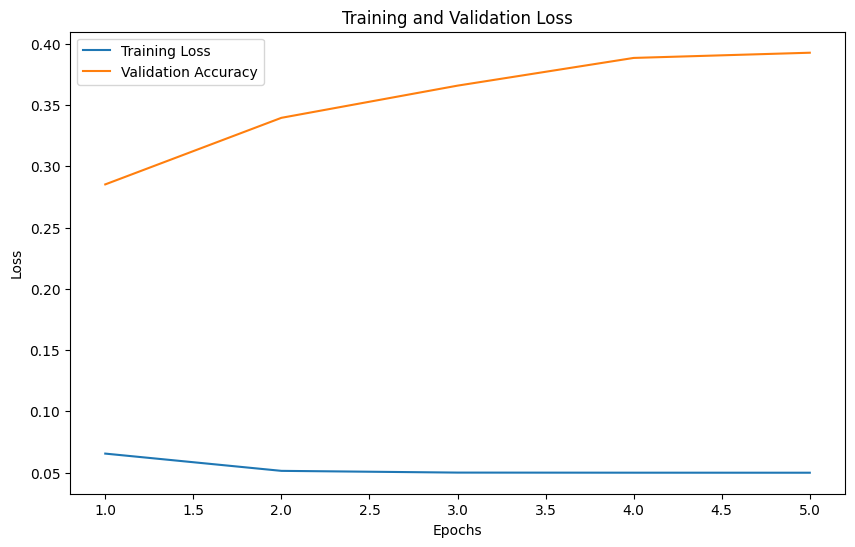

In [24]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [25]:
linear_nn.eval()

correct_top1 = 0
correct_top3 = 0
# Let's calculate the accuracy on the validation set
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        y = index_map[batch[1].to(device)]

        outputs = linear_nn(X)

        # Top-1 accuracy
        labels_top1 = outputs.argmax(dim=1)
        correct_top1 += (labels_top1 == y).sum()

        # Top-3 accuracy
        top3_preds = torch.topk(outputs, k=3, dim=1).indices
        correct_top3 += sum([y[j] in top3_preds[j] for j in range(len(y))])

# Calculate overall accuracy
accuracy_top1 = correct_top1.item() / len(X_val)
accuracy_top3 = correct_top3 / len(X_val)

print("Top-1 Accuracy: ", accuracy_top1)
print("Top-3 Accuracy: ", accuracy_top3)

Top-1 Accuracy:  0.3927764892578125
Top-3 Accuracy:  0.5523406982421875


In [28]:
torch.save(linear_nn.state_dict(), 'saved_models/linear_probe_reduced.pth')
raise
# linear_nn.load_state_dict(torch.load("saved_models/linear_probe_sigmoid-bce_lr1e-3_epoch3_seed42.pth"))

### Load model

##### Some qualitative checks on the linear probe

In [ ]:
class LinearProbe(nn.Module):
    def __init__(self, hdim=hidden_dim, vocab_size=len(tokenizer)):
        super().__init__()
        self.fc1 = nn.Linear(hdim, vocab_size, bias=False)
        
    def forward(self, X):
        x = self.fc1(X)
        return x

linear_nn = LinearProbe()
linear_nn.to(device)

In [ ]:

model_path = 'saved_models/linear_probe_pinv-mse_lr1e-4_epoch4_exp7_lw60_pw0.5_seed42.pth'
linear_nn.load_state_dict(torch.load(model_path))
#linear_nn.load_state_dict(torch.load('saved_models/linear_probe_f2-f3_lr1e-3_epoch3_seed42_temp3.pth'))


Get the accuracy on the validation dataset

In [ ]:
linear_nn.eval()

correct = 0
# Let's calculate the accuracy on the validation set
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        y = batch[1].to(device)

        outputs = linear_nn(X)
        labels = outputs.argmax(dim=1)

        correct += (labels == y).sum()

print("Accuracy: ", correct.item()/X_val.shape[0])

Some manual qualititive checks

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

Check max and min values

In [ ]:
# for every X in val_dataloader, get the output from linear_nn and find the top prediction value and plot it
top_values = []
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        outputs = linear_nn(X)
        top_values.extend(outputs.max(dim=1).values.cpu().numpy())
        
plt.figure(figsize=(10, 6))
sns.histplot(top_values, bins=100)
plt.xlabel('Top Prediction Value')
plt.ylabel('Frequency')
plt.title('Top Prediction Value Distribution')
plt.show()


In [ ]:
# for every X in val_dataloader, get the output from linear_nn and find the top prediction value and plot it
top_values = []
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        outputs = linear_nn(X)
        top_values.extend(outputs.min(dim=1).values.cpu().numpy())
        
plt.figure(figsize=(10, 6))
sns.histplot(top_values, bins=100)
plt.xlabel('Min Prediction Value')
plt.ylabel('Frequency')
plt.title('Top Prediction Value Distribution')
plt.show()


In [ ]:
def compute_scores_batch(outputs, indices, epsilon=1e-8, alpha=3):
    """
    Args:
        outputs (torch.Tensor): A 2D tensor of shape (batch_size, num_classes), containing the model's outputs.
        indices (torch.Tensor): A 1D tensor of shape (batch_size,), containing the target indices.
        epsilon (float): A small constant to avoid division by zero.
        alpha (float): A scaling factor to penalize smaller differences.
    Returns:
        torch.Tensor: A 1D tensor of scores for all samples in the batch.
    """
    # Gather the target values using indices
    batch_size = outputs.size(0)
    num_classes = outputs.size(1)

    # Select the target values for each sample
    v_target = outputs[torch.arange(batch_size), indices]

    # Compute the difference by subtracting outputs from target values
    diff = v_target.unsqueeze(1) - outputs

    # Exclude the target index by setting its difference to zero
    diff[torch.arange(batch_size), indices] = 0.0

    # Apply penalization: smaller differences are penalized more
    penalized_diff = diff ** alpha

    # Compute the average penalized difference for each sample
    scores = penalized_diff.sum(dim=1) / (num_classes - 1)

    return scores


# Process the entire validation set
all_scores = []

with torch.no_grad():
    for batch in val_dataloader:
        X = batch[0].to(device)  # Inputs
        y = batch[1].to(device)  # Target indices
        outputs = linear_nn(X)  # Model outputs (logits or predictions)

        # Compute batch scores without a loop
        batch_scores = compute_scores_batch(outputs, y)
        all_scores.append(batch_scores)

all_scores = torch.cat(all_scores, dim=0)

# Concatenate scores and compute the average score
average_score = torch.mean(all_scores)

print(f"Average Sparsity Score: {average_score.item()}")

In [ ]:
# for every X in val_dataloader, get the output from linear_nn and find the top prediction value and plot it
top_values = []
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        outputs = linear_nn(X)
        # find difference between top 2 values
        top2 = outputs.topk(10, dim=1).values.cpu().numpy()
        top_values.extend(top2[:,0] - top2[:, 1])
        
plt.figure(figsize=(10, 6))
sns.histplot(top_values, bins=100)
plt.xlabel('Top 2 Diff')
plt.ylabel('Frequency')
plt.title('Top 2 Diff Value Distribution')
plt.show()


In [24]:
# Check values like between -0.1 and 1
min = -0.31
max = 1.3
linear_nn.eval()
for i, batch in enumerate(val_dataloader):
    with torch.no_grad():
        X = batch[0].to(device)
        outputs = linear_nn(X)
        mask = (outputs <= min) | (outputs >= max)
        filtered_tensor = outputs[mask]
        assert filtered_tensor.shape[0] == 0, f"Invalid values found: {filtered_tensor}"

In [ ]:
linear_nn.eval()
# sample data from val_dataloader
X, y = next(iter(val_dataloader))
X = X.to(device)
y = y.to(device)
outputs = linear_nn(X)
# plot ouputs
plt.figure(figsize=(10, 6))
idx = 25

plt.plot(outputs[idx].detach().cpu().numpy())
top2 = outputs[idx].topk(2, dim=0).indices
print(top2)

print(tokenizer.convert_ids_to_tokens(top2))
print(y[idx])
plt.show()


In [ ]:
import torch.nn.functional as F

def calculate_entropy(logits):
    probabilities = F.softmax(logits, dim=-1)
    log_probabilities = F.log_softmax(logits, dim=-1)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1)
    return entropy

linear_nn.eval()
entropies = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        X = batch[0].to(device)
        outputs = linear_nn(X)
        entropy = calculate_entropy(outputs)
        entropies.append(entropy.cpu())

entropies = torch.cat(entropies).cpu().numpy()

plt.figure(figsize=(10, 6))
sns.histplot(entropies, bins=100, kde=True)
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution of Validation Outputs')
plt.show()

In [ ]:
idx = 40
plt.figure(figsize=(3, 3))
sns.histplot(outputs[idx].cpu(), bins=20, kde=True)
plt.show()

outputs[idx].topk(k=10)

In [ ]:
print("Mean: ", outputs[idx].mean().item())
print("Std Deviation: ", outputs[idx].std().item())

### Build watermark matrix

In [ ]:
unembedding = model.lm_head.weight.data


rng = torch.Generator(device=unembedding.device)

vocab_size = len(tokenizer)
gamma = 0.50
hash_key = 15485863


def prf_lookup(input_ids):
    return hash_key * input_ids[-1:].sum().item()


def get_partition(input_ids):
    prf_key = prf_lookup(input_ids)
    rng.manual_seed(prf_key % (2**64 - 1))

    greenlist_size = int(vocab_size * gamma)
    vocab_permutation = torch.randperm(
        vocab_size, device=unembedding.device, generator=rng)
    greenlist_ids = vocab_permutation[:greenlist_size].to("cpu")
    redlist_ids = vocab_permutation[greenlist_size:].to("cpu")
    return greenlist_ids, redlist_ids

# values x keys
watermark_matrix = torch.zeros(len(tokenizer), len(tokenizer))


for i in tqdm(range(len(tokenizer))):
    greenlist_ids, redlist_ids = get_partition(torch.tensor([i]))
    watermark_matrix[greenlist_ids, i] = 2.0
    watermark_matrix[redlist_ids, i] = 0

In [35]:
watermark_matrix = watermark_matrix.to(unembedding.device)
l = linear_nn.fc1.weight.data.to(unembedding.device)
deltas = torch.matmul(watermark_matrix, l)
assert unembedding.shape == deltas.shape
augmented_unembedding = unembedding + deltas

model.lm_head.weight.data = augmented_unembedding


In [19]:
    
test_text = "The cat sat on the "
inputs = tokenizer(test_text, return_tensors="pt").to(model.device)
with torch.no_grad():
    output = model.generate(
        **inputs, return_dict_in_generate=True,  max_length=10)



In [ ]:
seq = output.sequences[0]
tokenizer.decode(seq, skip_special_tokens=True)

Also do the analysis using the watermark matrix (what i mean when i say i want the logits to be close)

In [ ]:
watermark_matrix = torch.load("data/watermark_matrix_gamma0.50_simple1_key15485863.pt")

# dummy logits where everything is a small positive value
# probe_outputs = torch.ones((10, 50277), dtype=torch.float32)/10
probe_outputs = outputs
wm_predicted = einops.einsum(probe_outputs.cpu(), watermark_matrix.T, "b i, i j -> b j")

print("Watermark Delta Prediction: ", wm_predicted.shape)

In [78]:
greenlist_ids, redlist_ids = get_partition(torch.tensor([187]))

In [ ]:
print("Mean Green List: ", wm_predicted[0, greenlist_ids].mean().item())
print("Mean Red List: ", wm_predicted[0, redlist_ids].mean().item())

In [ ]:
plt.figure(figsize=(4, 3))
sns.histplot(wm_predicted[0, greenlist_ids].cpu(), bins=30, kde=True, color="green")
# sns.histplot(wm_predicted[0, redlist_ids].cpu(), bins=30, kde=True, color="red")
plt.show()

##### Magnitude of the Logits :- Clean Analysis of the Logits

##### Check how biased these logits are using this loss: f2 + f3 loss

In [ ]:
plt.figure(figsize=(4, 3))
sns.histplot(wm_predicted[7].cpu(), bins=30, kde=True)
plt.show()

In [62]:
greenlist_ids, redlist_ids = get_partition(torch.tensor([y[6]]))

In [ ]:
plt.figure(figsize=(4, 3))
sns.histplot(wm_predicted[6, greenlist_ids].cpu(), bins=30, kde=True, color="green")
sns.histplot(wm_predicted[6, redlist_ids].cpu(), bins=30, kde=True, color="red")
plt.show()

##### Check the MSE loss on the watermark logits 

In [15]:
watermark_matrix = torch.load("data/watermark_matrix_gamma0.50_simple1_key15485863.pt")
# watermark_matrix = watermark_matrix.to(device)

In [ ]:
mse_loss = nn.MSELoss()
linear_nn.eval()

total_loss = 0
with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader)):
        X = batch[0]
        y = batch[1]

        y_onehot = F.one_hot(y, num_classes=len(tokenizer)).to(torch.float32)
        y_onehot = y_onehot

        outputs = linear_nn(X.to(device))
        outputs = torch.sigmoid(outputs).to("cpu")

        wm_predicted = einops.einsum(outputs, watermark_matrix.T, "b i, i j -> b j")
        wm_gt = watermark_matrix[:, y].T

        loss = mse_loss(wm_predicted, wm_gt)
        total_loss += loss.item()

        if i >= 100:
            break

        #? to check if matrix mult is okay
        # wm_generated = einops.einsum(y_onehot, watermark_matrix.T, "b i, i j -> b j")
        # wm_gt = watermark_matrix[:, y].T
        # diff = wm_generated - wm_gt
        # print(diff.sum())

# len(val_dataloader) * val_dataloader.batch_size

In [ ]:
avg_val_loss = total_loss/100
print(avg_val_loss)

### Build the watermark matrix

Generate the watermark matrix and save it

In [ ]:
print("Device: ", device)

In [77]:
# the column i of this matrix should be the green-red split for the column i.
rng = torch.Generator(device=device)

vocab_size = len(tokenizer)
gamma = 0.50
hash_key = 15485863

def prf_lookup(input_ids):
    return hash_key * input_ids[-1:].sum().item()

def get_partition(input_ids):
    prf_key = prf_lookup(input_ids)
    rng.manual_seed(prf_key % (2**64 - 1))

    greenlist_size = int(vocab_size * gamma)
    vocab_permutation = torch.randperm(vocab_size, device=device, generator=rng)
    greenlist_ids = vocab_permutation[:greenlist_size].to("cpu")
    redlist_ids = vocab_permutation[greenlist_size:].to("cpu")
    return greenlist_ids, redlist_ids

In [ ]:
watermark_matrix = torch.zeros(len(tokenizer), len(tokenizer))

for i in tqdm(range(len(tokenizer))):
    greenlist_ids, redlist_ids = get_partition(torch.tensor([i]))
    watermark_matrix[greenlist_ids, i] = 1.0
    watermark_matrix[redlist_ids, i] = -1.0

In [9]:
torch.save(watermark_matrix, "data/watermark_matrix_gamma0.50_simple1_key15485863.pt")

Load the watermark matrix

In [12]:
watermark_matrix = torch.load("data/watermark_matrix_gamma0.50_simple1_key15485863.pt")

### Two Hidden Layer NN with second matrix frozen as the watermark matrix

Things tried

- Regression loss between the multi-hot encoded vectors and logits (does not work well).
- Formulate the problem as multi-label classification problem. `saved as config 2`
- Loss as the cosine similarity between the outputs of the model and watermark logits (make it +1 and -1).

TODO:

- [] Capped ReLU.
- [] Sparsity in the intermediate representation.

In [13]:
class WatermarkNetwork(nn.Module):
    def __init__(self, hdim=2048, vocab_size=len(tokenizer), watermark_matrix=None):
        super().__init__()
        self.fc1 = nn.Linear(hdim, vocab_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(vocab_size, vocab_size)

        # set the watermark matrix as the second layer
        self.fc2.weight = nn.Parameter(watermark_matrix, requires_grad=False)
        self.fc2.bias = nn.Parameter(torch.zeros(vocab_size), requires_grad=False)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        return self.fc2(x)

In [ ]:
wmNet = WatermarkNetwork(watermark_matrix=watermark_matrix)
wmNet.to(device)

In [15]:
# Will try training the neural network with a regression loss on the watermark outputs
batch_size = 64
learning_rate = 1e-3

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# freeze the second layer
wmNet.fc2.weight.requires_grad = False
wmNet.fc2.bias.requires_grad = False

# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(wmNet.parameters(), lr=learning_rate)

In [ ]:
for name, param in wmNet.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
# Count the total number of parameters
total_params = sum(p.numel() for p in wmNet.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    for i, batch  in tqdm(enumerate(train_dataloader)):
        
        X = batch[0].to(device)
        y = batch[1].to(device)

        output = wmNet(X)
        targets = watermark_matrix[:, y.to("cpu")]
        targets = targets.permute(1, 0).to(device)

        loss = criterion(output, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 1000 == 0:
            print(f'Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

In [44]:
torch.save(wmNet.state_dict(), 'saved_models/wm_config2.pth')

### Generate some text and (1) 